In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy_ext import rolling_apply

from qtrader.core.security import Security, Futures
from qtrader.core.constants import Exchange
from qtrader.core.data import _get_data
from qtrader.plugins.analysis.metrics import sharpe_ratio, rolling_maximum_drawdown
from qtalib.indicators import CYC
from qtrader_config import *

In [2]:
def load_data(
        security: Security,
        data_start: datetime,
        start: datetime,
        end: datetime,
        lookback_period: int = None
) -> pd.DataFrame:
    """Load OHLCV"""
    data = _get_data(
        security=security,
        start=data_start,
        end=end,
        dfield="kline",
        dtype=['time_key', 'open', 'high', 'low', 'close', 'volume']
    ).set_index("time_key")
    data = data.ffill().bfill()
    if data[data.index <= start].shape[0] < lookback_period:
        raise ValueError("There is not enough lookback data, change data_start")
    ret_data = pd.concat(
        [data[data.index <= start].iloc[-lookback_period:],
         data[data.index > start]]
    )
    return ret_data

In [3]:
security = Futures(
    code="HK.HSImain",
    lot_size=50,
    security_name="HK.HSImain",
    exchange=Exchange.HKFE,
    expiry_date="20221231"
)

# data_start = datetime(2020, 11, 15, 0, 0, 0)
# start = datetime(2021, 2, 1, 0, 0, 0)
# end = datetime(2022, 12, 1, 23, 59, 59)
# lookback_window = 194

data_start = datetime(2017, 1, 1, 0, 0, 0)
start = datetime(2018, 1, 1, 0, 0, 0)
end = datetime(2022, 12, 1, 23, 59, 59)
lookback_window = 160

# Load data
data = load_data(security, data_start, start, end, lookback_window)

2017-01-03 is not a valid date format! Return default datetime instead.
2018-01-02 is not a valid date format! Return default datetime instead.
2019-01-02 is not a valid date format! Return default datetime instead.
2020-01-02 is not a valid date format! Return default datetime instead.
2021-01-04 is not a valid date format! Return default datetime instead.


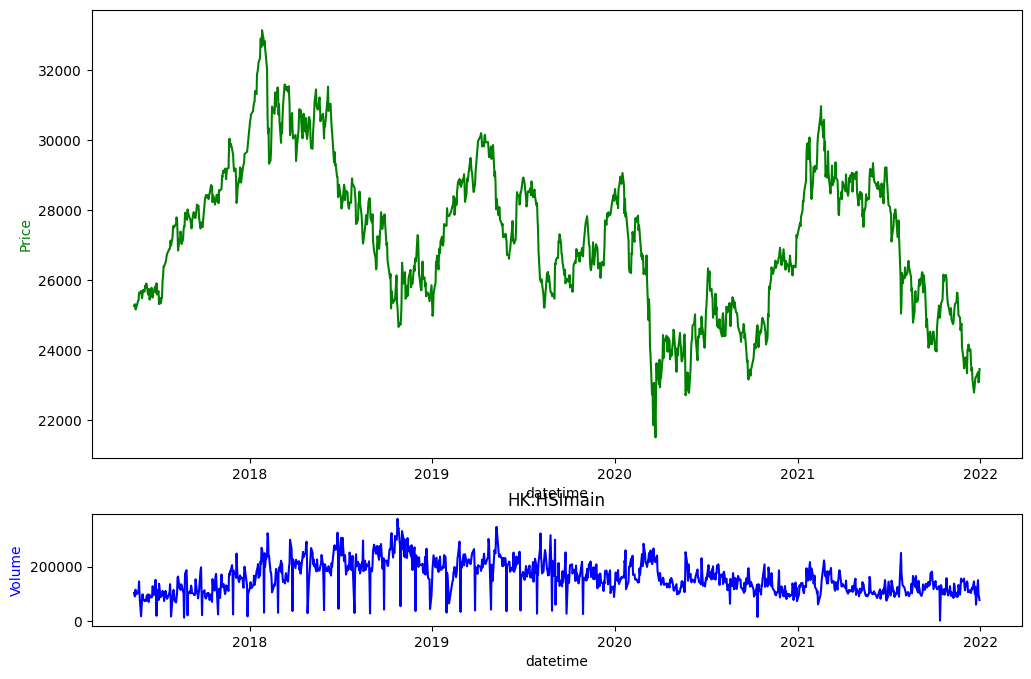

In [4]:
fig, (ax1, ax2) = plt.subplots(
    2, figsize=(12,8), gridspec_kw={'height_ratios': [4, 1]})
ax1.plot(data.index, data.close, 'g-')
ax1.set_xlabel('datetime')
ax1.set_ylabel('Price', color='g')
ax2.plot(data.index, data.volume, 'b-')
ax2.set_xlabel('datetime')
ax2.set_ylabel('Volume', color='b')
plt.title(security.code)
plt.show()

In [5]:
cyc = {
    "close": 0,
    "volume": 0
}
PCY = []
VOC = []
for idx in range(lookback_window, data.shape[0]):
    data_lb = data.iloc[idx-lookback_window+1:idx+1]
    closes = data_lb["close"].to_numpy(dtype=float)
    volumes = data_lb["volume"].to_numpy(dtype=float)
    cyc["close"] = CYC(
        data=closes,
        cyc=cyc["close"],
        short_ma_length=10,
        long_ma_length=50,
        alpha=0.29,
        lookback_window=10,
    )
    PCY.append(cyc["close"])
    cyc["volume"] = CYC(
        data=volumes,
        cyc=cyc["volume"],
        short_ma_length=30,
        long_ma_length=90,
        alpha=0.33,
        lookback_window=10,
    )
    VOC.append(cyc["volume"])

In [6]:
data_bt = data.iloc[lookback_window:].copy()
data_bt["VOC"] = VOC
data_bt["PCY"] = PCY

## Correlation

Check Pearson correlation between PCY and prices

In [7]:
def corr(x, y):
    return np.corrcoef(x, y)[0][1]

In [8]:
n = len(data_bt) // 3
rolling_corr_pcy = rolling_apply(
    corr,
    n,
    data_bt.PCY.diff().apply(lambda x: np.sign(x)).dropna().values,
    data_bt.close.diff().apply(lambda x: np.sign(x)).dropna().values
)
rolling_corr_pcy = rolling_corr_pcy[~np.isnan(rolling_corr_pcy)]

Check correlation between VOC and volumes

In [9]:
n = len(data_bt) // 3
rolling_corr_voc = rolling_apply(
    corr,
    n,
    data_bt.VOC.diff().apply(lambda x: np.sign(x)).dropna().values,
    data_bt.volume.diff().apply(lambda x: np.sign(x)).dropna().values
)
rolling_corr_voc = rolling_corr_voc[~np.isnan(rolling_corr_voc)]


In [10]:
print(
    f"VOC range: [{data_bt['VOC'].min()}, {data_bt['VOC'].max()}]\n"
    f"Correlation(VOC, price_trends): "
    f"[{rolling_corr_voc.min()}, {rolling_corr_voc.max()}],"
    f"mean={rolling_corr_voc.mean()}\n"
    f"PCY range: [{data_bt['PCY'].min()}, {data_bt['PCY'].max()}]\n"
    f"Correlation(PCY, price): "
    f"[{rolling_corr_pcy.min()}, {rolling_corr_pcy.max()}],"
    f"mean={rolling_corr_pcy.mean()}\n"
)


VOC range: [0.0010759167051401805, 99.99396024545634]
Correlation(VOC, price_trends): [0.06417507710161074, 0.20310869851274127],mean=0.13151101403817023
PCY range: [0.0049844894731519915, 99.99672537487147]
Correlation(PCY, price): [0.026779115270778267, 0.16358903856995743],mean=0.09745534602584428



buy & sell signals

In [11]:
pcy_mean = data_bt.PCY.mean()
pcy_std = data_bt.PCY.std()
voc_mean = data_bt.VOC.mean()
voc_std = data_bt.VOC.std()
print(
    f"PCY mean: {pcy_mean}; PCY std: {pcy_std}\n"
    f"VOC mean: {voc_mean}; VOC std: {voc_std}"
)

PCY mean: 52.23488321393533; PCY std: 39.16166087247148
VOC mean: 54.607694844365504; VOC std: 38.62839859946099


In [24]:
# data_bt["entry_long1"] = rolling_apply(
#     lambda VOC: int(VOC[0]>VOC[1] and VOC[2]>VOC[1]),
#     3,
#     data_bt.VOC.values
# )
# data_bt["entry_long2"] = rolling_apply(
#     lambda VOC, PCY: int(VOC[0]>VOC[1] and VOC[2]>VOC[1] and PCY[2]>PCY[1]),
#     3,
#     data_bt.VOC.values, data_bt.PCY.values
# )

# VOC bottom, PCY bottom
pcy_entry_long_threshold = 20
voc_entry_long_threshold = 20
data_bt["entry_long"] = rolling_apply(
    lambda VOC, PCY: int(
        VOC[0] > VOC[1]
        and VOC[2] > VOC[1]
        and VOC[1] < voc_entry_long_threshold
        and PCY[2] > PCY[1]
        and PCY[2] < pcy_entry_long_threshold
    ),
    3,
    data_bt.VOC.values, data_bt.PCY.values
)
# VOC bottom, PCY top
pcy_entry_short_threshold = 80
voc_entry_short_threshold = 20
data_bt["entry_short"] = rolling_apply(
    lambda VOC, PCY: int(
        VOC[0] > VOC[1]
        and VOC[2] > VOC[1]
        and VOC[1] < voc_entry_short_threshold
        and PCY[2] < PCY[1]
        and PCY[2] > pcy_entry_short_threshold
    ),
    3,
    data_bt.VOC.values, data_bt.PCY.values
)
# PCY top, VOC top
# pcy_exit_long_threshold = 80
voc_exit_long_threshold = 90
data_bt["exit_long"] = rolling_apply(
    lambda VOC, PCY: int(
        # PCY[0] < PCY[1]
        # and PCY[1] > PCY[2]
        # and PCY[1] > pcy_exit_long_threshold
        VOC[2] < VOC[1]
        and VOC[2] > voc_exit_long_threshold
    ),
    3,
    data_bt.VOC.values, data_bt.PCY.values
)
# PCY bottom, VOC top
# pcy_exit_short_threshold = 20
voc_exit_short_threshold = 90
data_bt["exit_short"] = rolling_apply(
    lambda VOC, PCY: int(
        # PCY[0] > PCY[1]
        # and PCY[1] < PCY[2]
        # and PCY[1] < pcy_exit_short_threshold
        VOC[2] < VOC[1]
        and VOC[2] > voc_exit_short_threshold
    ),
    3,
    data_bt.VOC.values, data_bt.PCY.values
)

In [25]:
data_bt_plot = data_bt[
    (data_bt.index > datetime(2021, 2, 10))
    & (data_bt.index < datetime(2021, 2, 20))
]
data_bt_plot_entry_long = data_bt_plot[data_bt_plot.entry_long==1]
data_bt_plot_exit_long = data_bt_plot[data_bt_plot.exit_long==1]
data_bt_plot_entry_short = data_bt_plot[data_bt_plot.entry_short==1]
data_bt_plot_exit_short = data_bt_plot[data_bt_plot.exit_short==1]

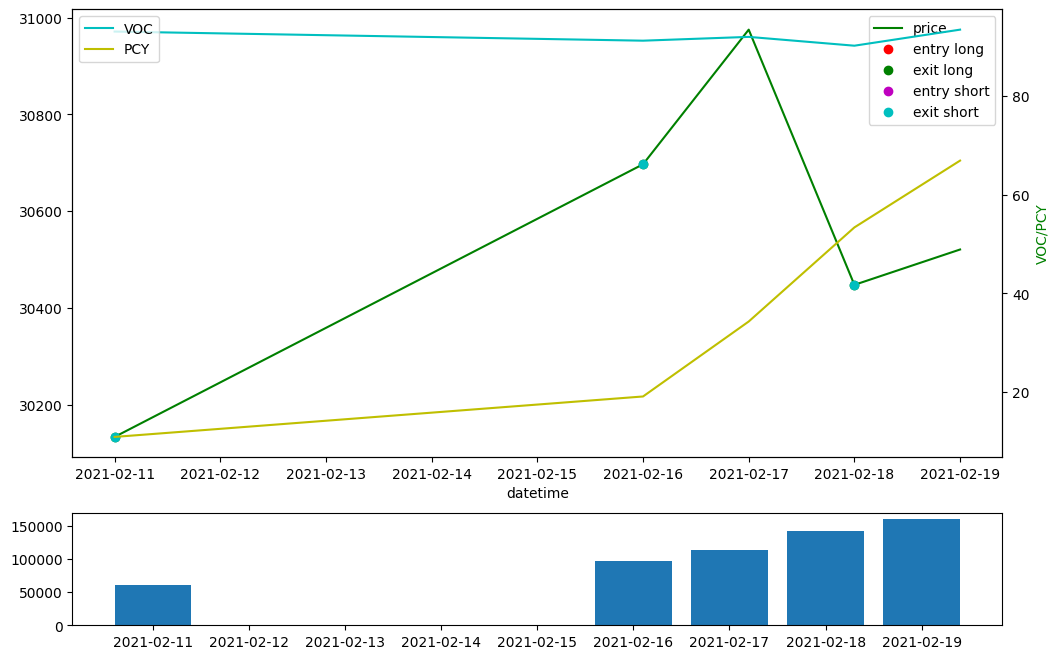

In [26]:
fig, (ax1, ax3) = plt.subplots(
    2, figsize=(12,8), gridspec_kw={'height_ratios': [4, 1]})
ax2 = ax1.twinx()
ax1.plot(data_bt_plot.index, data_bt_plot.close, 'g-', label='price')
ax1.plot(data_bt_plot_entry_long.index,
         data_bt_plot_entry_long.close, 'ro', label='entry long')
ax1.plot(data_bt_plot_exit_long.index,
         data_bt_plot_exit_long.close, 'go', label='exit long')
ax1.plot(data_bt_plot_entry_short.index,
         data_bt_plot_entry_short.close, 'mo', label='entry short')
ax1.plot(data_bt_plot_exit_short.index,
         data_bt_plot_exit_short.close, 'co', label='exit short')
ax2.plot(data_bt_plot.index, data_bt_plot.VOC, 'c-', label='VOC')
ax2.plot(data_bt_plot.index, data_bt_plot.PCY, 'y-', label='PCY')
ax1.legend(loc=0)
ax2.legend(loc=2)
ax1.set_xlabel('datetime')
ax2.set_ylabel('Price', color='b')
ax2.set_ylabel('VOC/PCY', color='g')
ax3.bar(data_bt_plot.index, data_bt_plot.volume, label='volume')

plt.show()


Long only

In [27]:
entry_long_signal = "entry_long"
exit_long_signal = "exit_long"
stop_loss = 0.01
pos = 0
open_time_lst = []
cost_lst = []
trades = []
stop_trades = []
pnls = []
for i in range(len(data_bt)):
    row = data_bt.iloc[i]
    dt = row.index
    pnl = 0
    if row[entry_long_signal] == 1:
        pos += 1
        cost_lst.append(row.close)
        open_time_lst.append(dt)
    elif pos > 0:
        # stop loss
        close_long = []
        for idx, cost in enumerate(cost_lst):
            if (row.close-cost)/cost < -stop_loss:
                close_long.append(idx)
                pos -= 1
                open_time = open_time_lst[idx]
                close_time = dt
                prev_row = data_bt.iloc[i-1]
                pnl += (row.close - prev_row.close) / cost
                cum_pnl = (row.close - cost) / cost
                trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
                stop_trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
            else:
                prev_row = data_bt.iloc[i-1]
                pnl += (row.close - prev_row.close) / cost
        cost_lst = [cost_lst[i] for i in range(len(cost_lst))
                    if i not in close_long]
        open_time_lst = [open_time_lst[i] for i in range(len(open_time_lst))
                    if i not in close_long]
        # if exit long signal
        if pos > 0 and row[exit_long_signal] == 1:
            idx = cost_lst.index(min(cost_lst))
            cost = cost_lst.pop(idx)
            open_time = open_time_lst.pop(idx)
            close_time = dt
            pos -= 1
            cum_pnl = (row.close - cost) / cost
            trades.append([
                open_time,
                close_time,
                cum_pnl
            ])
    pnls.append(pnl)
data_bt["equity"] = np.cumsum(pnls)

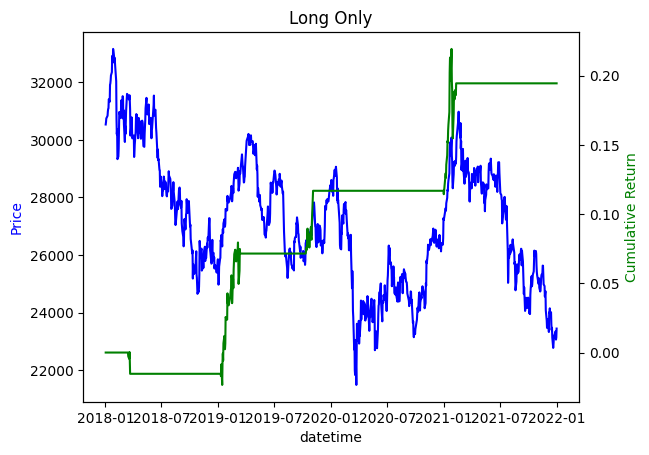

In [28]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(data_bt.index, data_bt.close, 'b-')
ax2.plot(data_bt.index, data_bt.equity, 'g-')
ax1.set_xlabel('datetime')
ax1.set_ylabel('Price', color='b')
ax2.set_ylabel('Cumulative Return', color='g')
plt.title("Long Only")
plt.show()

In [29]:
num_trades = len(trades)
num_stop_trades = len(stop_trades)
trades_pnl = [t[-1] for t in trades]
win_trades_pnl = [t[-1] for t in trades if t[-1]>0]
num_win_trades = len(win_trades_pnl)
lose_trades_pnl = [t[-1] for t in trades if t[-1]<=0]
num_lose_trades = len(lose_trades_pnl)
stop_trades_pnl = [t[-1] for t in stop_trades]
df_daily = data_bt.resample('D').agg(
    {"equity": "last"}).dropna()
sr = sharpe_ratio(
    returns=df_daily["equity"].diff().dropna(),
    days=252
)

In [30]:
print(
    "________ <Long Only> ________\n"
    f"number of trades: {num_trades}\n"
    f"number of stop trades: {num_stop_trades}\n"
    f"number of win trades: {num_win_trades}\n"
    f"number of lose trades: {num_lose_trades}\n"
    f"win trade ratio: {num_win_trades/num_trades}\n"
    f"maximum win trade: {max(trades_pnl)}\n"
    f"maximum lose trade: {min(trades_pnl)}\n"
    f"Sharpe ratio: {sr}\n"
)

________ <Long Only> ________
number of trades: 4
number of stop trades: 1
number of win trades: 3
number of lose trades: 1
win trade ratio: 0.75
maximum win trade: 0.0868187818216104
maximum lose trade: -0.015348026002853971
Sharpe ratio: 1.0186747837205454



Long Short

In [19]:
entry_long_signal = "entry_long"
exit_long_signal = "exit_long"
entry_short_signal = "entry_short"
exit_short_signal = "exit_short"
long_stop_loss = 0.01
short_stop_loss = 0.01
pos = 0
open_time_lst = []
cost_lst = []
trades = []
stop_trades = []
pnls = []
for i in range(len(data_bt)):
    row = data_bt.iloc[i]
    dt = row.index
    pnl = 0
    if row[entry_long_signal] == 1:
        # close short
        if pos < 0:
            for idx, cost in enumerate(cost_lst):
                pos += 1
                close_time = dt
                open_time = open_time_lst[idx]
                prev_row = data_bt.iloc[i-1]
                pnl += -(row.close - prev_row.close) / cost
                cum_pnl = -(row.close - cost) / cost
                trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
            assert pos == 0, "position incorrect"
            cost_lst = []
            open_time_lst = []
        # open long
        pos += 1
        cost_lst.append(row.close)
        open_time_lst.append(dt)
    elif row[entry_short_signal] == 1:
        # close long
        if pos > 0:
            for idx, cost in enumerate(cost_lst):
                pos -= 1
                close_time = dt
                open_time = open_time_lst[idx]
                prev_row = data_bt.iloc[i-1]
                pnl += (row.close - prev_row.close) / cost
                cum_pnl = (row.close - cost) / cost
                trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
            assert pos == 0, "position incorrect"
            cost_lst = []
            open_time_lst = []
        # open short
        pos -= 1
        cost_lst.append(row.close)
        open_time_lst.append(dt)
    elif pos > 0:
        # stop loss
        close_long = []
        for idx, cost in enumerate(cost_lst):
            if (row.close-cost)/cost < -long_stop_loss:
                close_long.append(idx)
                pos -= 1
                open_time = open_time_lst[idx]
                close_time = dt
                prev_row = data_bt.iloc[i-1]
                pnl += (row.close - prev_row.close) / cost
                cum_pnl = (row.close - cost) / cost
                trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
                stop_trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
            else:
                prev_row = data_bt.iloc[i-1]
                pnl += (row.close - prev_row.close) / cost
        cost_lst = [cost_lst[i] for i in range(len(cost_lst))
                    if i not in close_long]
        open_time_lst = [open_time_lst[i] for i in range(len(open_time_lst))
                    if i not in close_long]
        # if exit long signal
        if pos > 0 and row[exit_long_signal] == 1:
            idx = cost_lst.index(min(cost_lst))
            cost = cost_lst.pop(idx)
            open_time = open_time_lst.pop(idx)
            close_time = dt
            pos -= 1
            cum_pnl = (row.close - cost) / cost
            trades.append([
                open_time,
                close_time,
                cum_pnl
            ])
    elif pos < 0:
        # stop loss
        close_short = []
        for idx, cost in enumerate(cost_lst):
            if -(row.close-cost)/cost < -short_stop_loss:
                close_short.append(idx)
                pos += 1
                open_time = open_time_lst[idx]
                close_time = dt
                prev_row = data_bt.iloc[i-1]
                pnl += -(row.close - prev_row.close) / cost
                cum_pnl = -(row.close - cost) / cost
                trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
                stop_trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
            else:
                prev_row = data_bt.iloc[i-1]
                pnl += -(row.close - prev_row.close) / cost
        cost_lst = [cost_lst[i] for i in range(len(cost_lst))
                    if i not in close_short]
        open_time_lst = [open_time_lst[i] for i in range(len(open_time_lst))
                    if i not in close_short]
        # if exit short signal
        if pos < 0 and row[exit_short_signal] == 1:
            idx = cost_lst.index(max(cost_lst))
            cost = cost_lst.pop(idx)
            open_time = open_time_lst.pop(idx)
            close_time = dt
            pos += 1
            cum_pnl = -(row.close - cost) / cost
            trades.append([
                open_time,
                close_time,
                cum_pnl
            ])
    pnls.append(pnl)
data_bt["equity"] = np.cumsum(pnls)

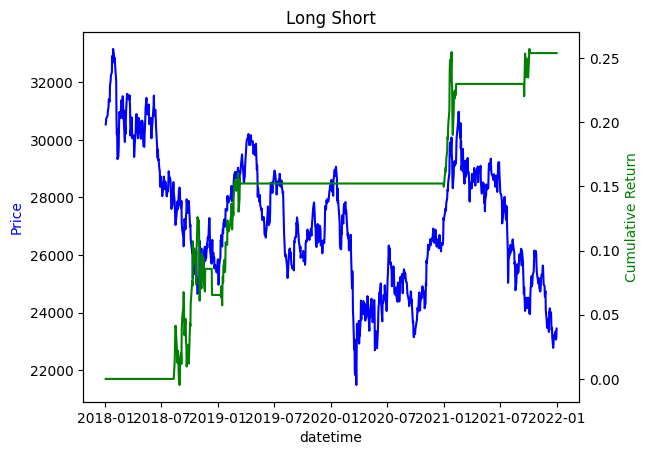

In [20]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(data_bt.index, data_bt.close, 'b-')
ax2.plot(data_bt.index, data_bt.equity, 'g-')
ax1.set_xlabel('datetime')
ax1.set_ylabel('Price', color='b')
ax2.set_ylabel('Cumulative Return', color='g')
plt.title("Long Short")
plt.show()

In [21]:
num_trades = len(trades)
num_stop_trades = len(stop_trades)
trades_pnl = [t[-1] for t in trades]
win_trades_pnl = [t[-1] for t in trades if t[-1]>0]
num_win_trades = len(win_trades_pnl)
lose_trades_pnl = [t[-1] for t in trades if t[-1]<=0]
num_lose_trades = len(lose_trades_pnl)
stop_trades_pnl = [t[-1] for t in stop_trades]
df_daily = data_bt.resample('D').agg(
    {"equity": "last"}).dropna()
sr = sharpe_ratio(
    returns=df_daily["equity"].diff().dropna(),
    days=252
)

In [22]:
print(
    "________ <Long Short> ________\n"
    f"number of trades: {num_trades}\n"
    f"number of stop trades: {num_stop_trades}\n"
    f"number of win trades: {num_win_trades}\n"
    f"number of lose trades: {num_lose_trades}\n"
    f"win trade ratio: {num_win_trades/num_trades}\n"
    f"maximum win trade: {max(trades_pnl)}\n"
    f"maximum lose trade: {min(trades_pnl)}\n"
    f"Sharpe ratio: {sr}\n"
)


________ <Long Short> ________
number of trades: 5
number of stop trades: 1
number of win trades: 4
number of lose trades: 1
win trade ratio: 0.8
maximum win trade: 0.0868187818216104
maximum lose trade: -0.020338323935446236
Sharpe ratio: 0.8269380483481202



In [23]:
data_bt.VOC.mean()

54.607694844365504